In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import unzip_file, minimize_memory_usage

In [ ]:
unzip_file("home-credit-default-risk.zip","data")

### **Reduce Memory Usage of DataFrame**

In [2]:
main = pd.read_csv(r"data/application_train.csv")
main = minimize_memory_usage(main, "application_train.csv")

Memory usage of application_train.csv before optimization: 173.47 MB
Memory usage of application_train.csv after optimization: 60.78 MB


In [3]:
description = pd.read_csv("data/HomeCredit_columns_description.csv", encoding='ISO-8859-1')
description = minimize_memory_usage(description, "HomeCredit_columns_description.csv")

Memory usage of HomeCredit_columns_description.csv before optimization: 0.01 MB
Memory usage of HomeCredit_columns_description.csv after optimization: 0.01 MB


In [49]:
bureau = pd.read_csv(r"data/bureau.csv")
bureau = minimize_memory_usage(bureau, "bureau.csv")

Memory usage of bureau.csv before optimization: 222.62 MB
Memory usage of bureau.csv after optimization: 112.95 MB


### **DataFrame Characteristics**

In [5]:
print("Shape:", main.shape)

Shape: (186364, 122)


In [6]:
main.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [7]:
main.duplicated().sum()

np.int64(0)

- No Duplicate Rows.

### **Fetch Data Description from HomeCredit_coulmns_description.csv**

In [ ]:
column_list = main.columns

column_description = {}
for col in column_list:
    column_description[col] = description[description["Row"]==col]["Description"].values[0]
column_description

### **Missing Values Analysis and Handling**

In [9]:
missingness_more_than_50_percent = []
for col in list(main.columns):
    if (main[col].isnull().sum()/main.shape[0])*100 > 50:
        missingness_more_than_50_percent.append(col)
len(missingness_more_than_50_percent)

41

##### REMOVING COLUMNS HAVING NULL VALUES GREATER THAN 50%

In [10]:
main.drop(columns=missingness_more_than_50_percent,inplace=True)

##### CREATING NAN FLAGS AND IMPUTATIONS FOR COLUMNS HAVING NULL VALUES

- Creating flags for columns having null values so that the model can understand missingess patterns.
- Imputing the missing values with median (Used median for robustness) for numeric columns and mode for categorical columns.

In [11]:
greater_than_10 = []
for col in list(main.columns):
    if (main[col].isnull().sum()/main.shape[0])*100 > 10:
        greater_than_10.append(col)
print("No. of columns having null values greater than 10%:",len(greater_than_10))

less_than_or_equal_to_10 = []
for col in list(main.columns):
    if (main[col].isnull().sum()/main.shape[0])*100 < 10:
        less_than_or_equal_to_10.append(col)
print("No. of columns having null values less than 10%:",len(less_than_or_equal_to_10))

No. of columns having null values greater than 10%: 16
No. of columns having null values less than 10%: 65


- Creating NAN Flags would be a wise decision for columns having missingness more than 10% to capture any missingness pattern.
- For rest of the columns we will just do imputation.

In [ ]:
median_dict = {}
mode_dict = {}

for col in greater_than_10:
    if col in main.columns:
        main[f'{col}_NAN_FLAG'] = main[col].isnull().astype(int)
        
        if main[col].dtype in ['float64', 'int64']:
            median_val = main[col].median()
            median_dict[col] = median_val if pd.notna(median_val) else 0
            main[col].fillna(median_dict[col], inplace=True)
        else:
            mode_val = main[col].mode()[0]
            mode_dict[col] = mode_val
            main[col].fillna(mode_dict[col], inplace=True)

for col in less_than_or_equal_to_10:
    if main[col].dtype in ['float64', 'int64']:
        median_val = main[col].median()
        median_dict[col] = median_val if pd.notna(median_val) else 0
        main[col].fillna(median_dict[col], inplace=True)
    else:
        mode_val = main[col].mode()[0]
        mode_dict[col] = mode_val
        main[col].fillna(mode_dict[col], inplace=True)


In [13]:
# No Null Values left.

main.isnull().any().sum()

np.int64(0)

### **Correcting DataTypes and Fixing Invalid Values**


In [14]:
# Getting Age of Applicant in Years

main['AGE_YEARS'] = (-main['DAYS_BIRTH']) // 365
main.drop(columns = "DAYS_BIRTH", inplace = True)

In [15]:
# Employment Tenure in Years

main['YEARS_EMPLOYED'] = (-main['DAYS_EMPLOYED']) // 365
main.drop(columns = "DAYS_EMPLOYED", inplace = True)

In [16]:
main['YEARS_REGISTRATION'] = (-main['DAYS_REGISTRATION']) // 365
main.drop(columns = "DAYS_REGISTRATION", inplace = True)

In [17]:
main['YEARS_ID_PUBLISH'] = (-main['DAYS_ID_PUBLISH']) // 365
main.drop(columns = "DAYS_ID_PUBLISH", inplace = True)

In [18]:
main = main[main["CODE_GENDER"]!="XNA"]

### **Feature Engineering**

In [ ]:
# Percentage of Defaulters in total Social Circle of a Candidate.

main["DEF_30_RATIO"] = main["DEF_30_CNT_SOCIAL_CIRCLE"] / main["OBS_30_CNT_SOCIAL_CIRCLE"].replace(0, np.nan) * 100
main["DEF_60_RATIO"] = main["DEF_60_CNT_SOCIAL_CIRCLE"] / main["OBS_60_CNT_SOCIAL_CIRCLE"].replace(0, np.nan) * 100

main["DEF_30_RATIO"].fillna(0, inplace=True)
main["DEF_60_RATIO"].fillna(0, inplace=True)


In [ ]:
# Income by Credit Ratio.

main["INCOME_BY_CREDIT"] = main["AMT_INCOME_TOTAL"]/main["AMT_CREDIT"]

In [ ]:
# Amount of Goods by Credit Ratio.

main["GOODS_AMT_BY_CREDIT"] = main["AMT_GOODS_PRICE"]/main["AMT_CREDIT"]

In [ ]:
# Creating Age Bins

bins = [0, 14, 25, 59, main['AGE_YEARS'].max()] 
labels = ['1–14', '15–25', '26–59', '60+']
main['AGE_BIN'] = pd.cut(main['AGE_YEARS'], bins=bins, labels=labels, right=True)

In [ ]:
# Amount Annuity by Income Ration.

main["ANNUITY_BY_INCOME"] = main["AMT_ANNUITY"]/main["AMT_INCOME_TOTAL"]

### **Reducing Redundant Columns**

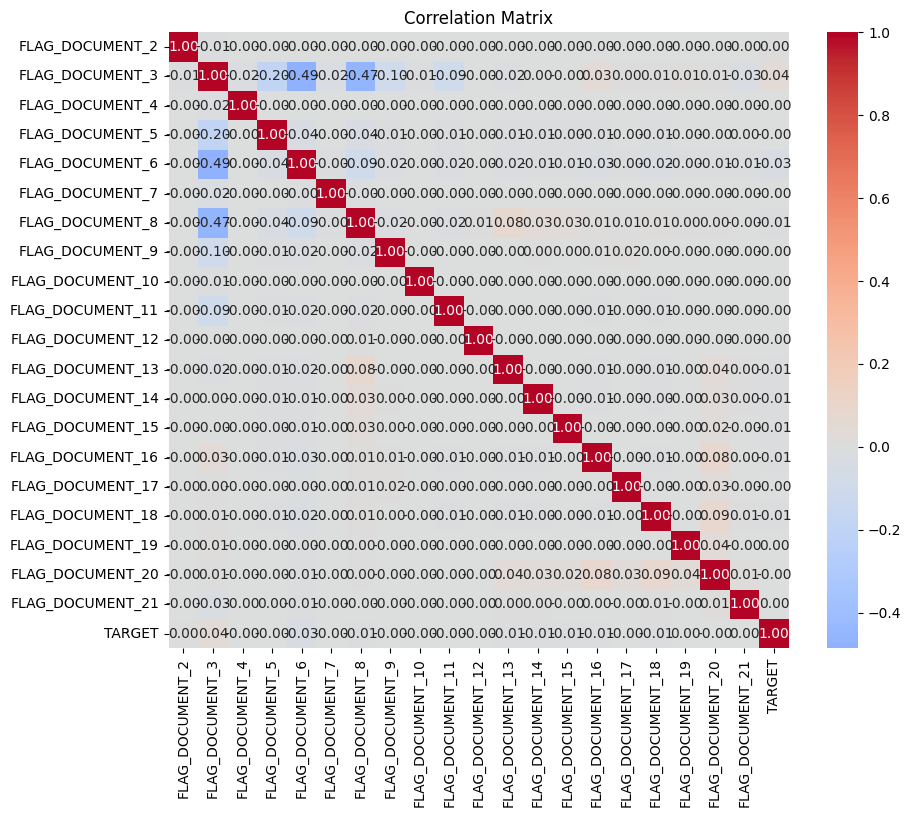

In [26]:
# Dropping all the FLAG_DOCUMENT columns. 

columns =  ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4',
            'FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7', 
            'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10',
            'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13', 
            'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 
            'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19', 
            'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21',"TARGET"]

docs = main[columns]
correlation_matrix = docs.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

- No Correlation between these Docs' Flags and Target.

In [ ]:
# Dropping Redundant Columns

redundant_cols = main[columns[:-1]]
main.drop(columns = redundant_cols,inplace=True)

In [ ]:
# Dropping Redundant Columns 

redundant_features = ["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_MON","AMT_REQ_CREDIT_BUREAU_WEEK",
                      "CNT_CHILDREN", "YEARS_BEGINEXPLUATATION_MODE", "FLOORSMAX_MODE", "YEARS_BEGINEXPLUATATION_MEDI", "FLOORSMAX_MEDI", 
                      "EMERGENCYSTATE_MODE", "TOTALAREA_MODE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "OBS_30_CNT_SOCIAL_CIRCLE",
                      "DEF_30_CNT_SOCIAL_CIRCLE", "LIVE_CITY_NOT_WORK_CITY", "REGION_RATING_CLIENT", "REG_CITY_NOT_WORK_CITY", "REG_CITY_NOT_LIVE_CITY",
                      "HOUR_APPR_PROCESS_START", "WEEKDAY_APPR_PROCESS_START", "REGION_RATING_CLIENT_W_CITY", "REGION_RATING_CLIENT",
                      "FLAG_EMAIL","FLAG_PHONE","FLAG_WORK_PHONE", "FLAG_EMP_PHONE", "FLAG_MOBIL", "REGION_POPULATION_RELATIVE", "NAME_TYPE_SUITE",
                      'YEARS_BEGINEXPLUATATION_MODE_NAN_FLAG', 'YEARS_BEGINEXPLUATATION_MEDI_NAN_FLAG', 'TOTALAREA_MODE_NAN_FLAG', 'FLOORSMAX_MODE_NAN_FLAG', 
                      'FLOORSMAX_MEDI_NAN_FLAG', 'EMERGENCYSTATE_MODE_NAN_FLAG', 'AMT_REQ_CREDIT_BUREAU_HOUR_NAN_FLAG', 'AMT_REQ_CREDIT_BUREAU_DAY_NAN_FLAG',
                      'AMT_REQ_CREDIT_BUREAU_WEEK_NAN_FLAG', 'AMT_REQ_CREDIT_BUREAU_MON_NAN_FLAG', 'AMT_REQ_CREDIT_BUREAU_QRT_NAN_FLAG', 
                      "AMT_REQ_CREDIT_BUREAU_DAY"]
                      

main.drop(columns = redundant_features,inplace = True)

- AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_WEEK->  We will just keep AMT_REQ_CREDIT_BUREAU_YEAR which gives total inquiries in the past year (broad overview).

- CNT_CHILDREN:-> Total number of family members is already given so a seperate count of children is not necessary.

- YEARS_BEGINEXPLUATATION_MODE, FLOORSMAX_MODE, YEARS_BEGINEXPLUATATION_MEDI, FLOORSMAX_MEDI, EMERGENCYSTATE_MODE, TOTALAREA_MODE:-> Just keeping their average values in the data.

- OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE:-> New and more insightful features have been generated from them.

In [29]:
print("Total number of Columns left: ",main.shape[1])

Total number of Columns left:  42


### **Outlier Detection**

In [ ]:
print("PERCENTAGE OF OUTLIERS IN EACH COLUMN: ","\n")
for col in main.columns:
    if main[col].dtypes != "object":
        Q1 = main[col].quantile(0.25)
        Q3 = main[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        num_of_otliers = main[(main[col] < lower_bound) | (main[col] > upper_bound)]
        print(f"{col}: {(num_of_otliers.shape[0]/main.shape[0])*100}")

### **Visualizations and EDA**

#### 1. BORROWER ATTRIBUTES

    'SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'AGE_YEARS', 'YEARS_EMPLOYED', 'AGE_BIN'
    'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH'

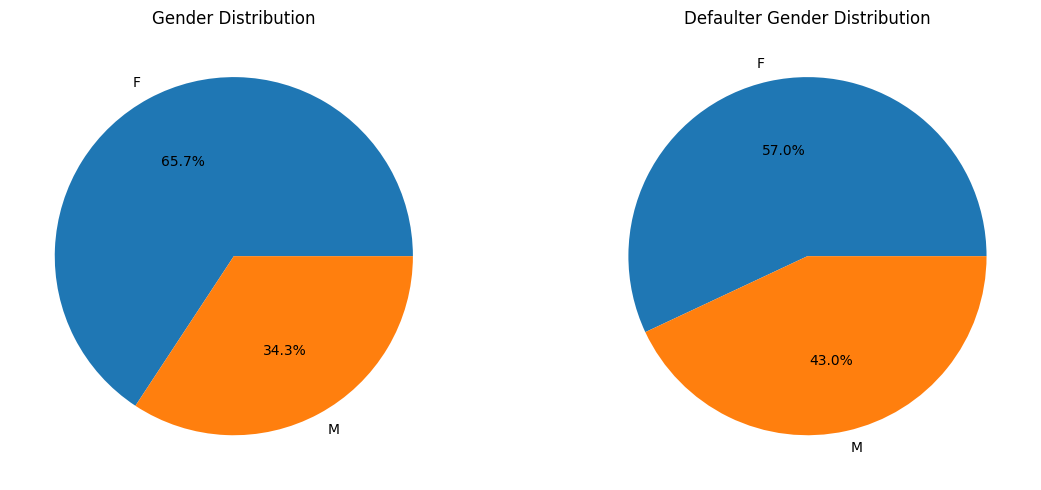

In [31]:
# Total Gender Distribution and Defaulter Gender Distribution

plt.figure(figsize=(12, 5))  

# Plot 1
plt.subplot(1, 2, 1) 
gender_dist = main['CODE_GENDER'].value_counts()
gender_dist.plot.pie(autopct='%1.1f%%', title='Gender Distribution') 
plt.ylabel("")

# Plot 2
plt.subplot(1, 2, 2)
target_dist = main[main['TARGET']==1]["CODE_GENDER"].value_counts()
target_dist.plot.pie(autopct='%1.1f%%', title='Defaulter Gender Distribution')
plt.ylabel("") 

plt.tight_layout()
plt.show()


- Almost similar defaulter gender distribution across data.

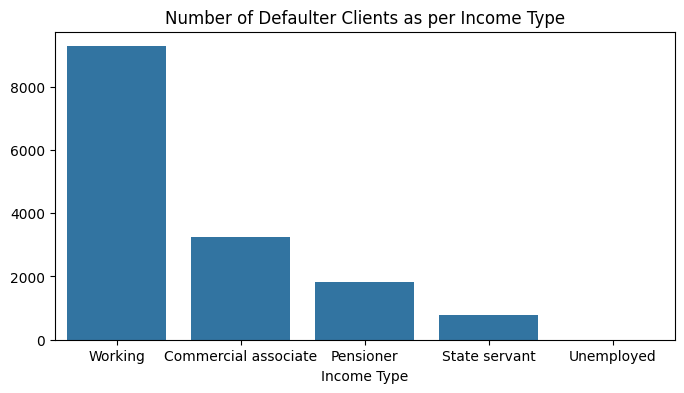

In [32]:
# Number of Defaulter Clients as per Income Type

plt.figure(figsize=(8,4))
sns.countplot(data=main[main["TARGET"]==1], x='NAME_INCOME_TYPE')
plt.title('Number of Defaulter Clients as per Income Type')
plt.xlabel('Income Type')

plt.ylabel("")
plt.show()

- Working people are more likely to be Defaulters.

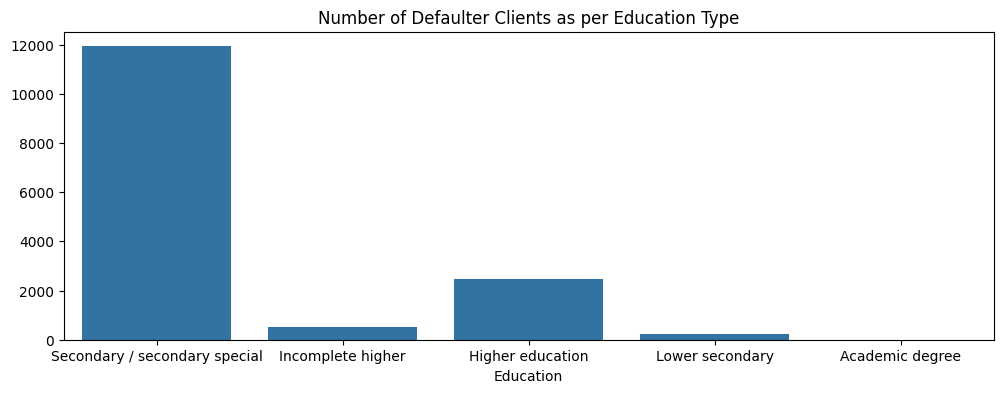

In [33]:
# Number of Defaulter Clients as per Education Type

plt.figure(figsize=(12,4))
sns.countplot(data=main[main["TARGET"]==1], x='NAME_EDUCATION_TYPE')
plt.title('Number of Defaulter Clients as per Education Type')
plt.xlabel('Education')

plt.ylabel("")
plt.show()

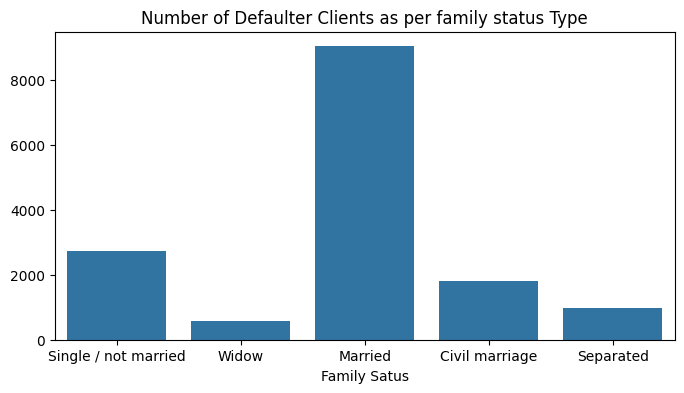

In [34]:
# Number of Defaulter Clients as per Family Status Type

plt.figure(figsize=(8,4))
sns.countplot(data=main[main["TARGET"]==1], x='NAME_FAMILY_STATUS')
plt.title('Number of Defaulter Clients as per family status Type')
plt.xlabel('Family Satus')

plt.ylabel("")
plt.show()

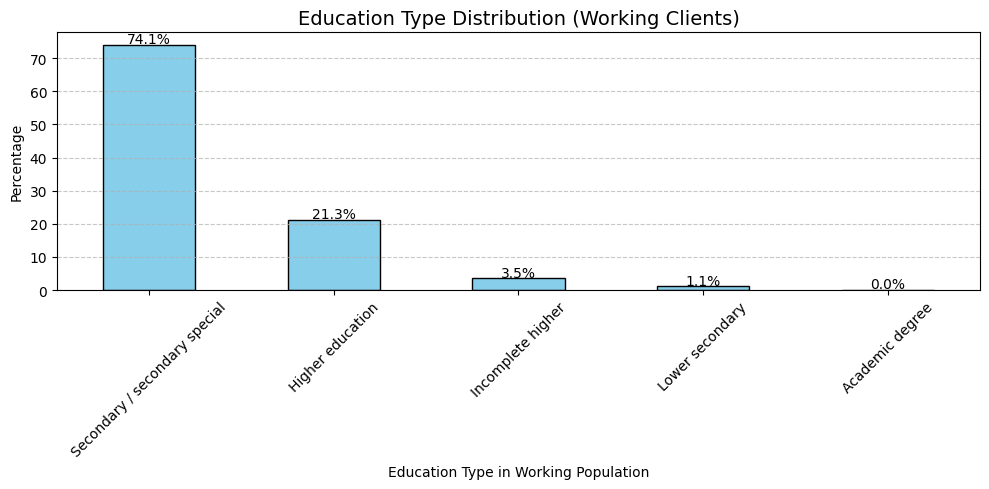

In [35]:
# Working Population's Education

edu_counts = main[main["NAME_INCOME_TYPE"] == "Working"]["NAME_EDUCATION_TYPE"].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 5))
edu_counts.plot(kind='bar', color='skyblue', edgecolor='black')

for index, value in enumerate(edu_counts):
    plt.text(index, value + 0.5, f'{value:.1f}%', ha='center', fontsize=10)

plt.title("Education Type Distribution (Working Clients)", fontsize=14)
plt.xlabel("Education Type in Working Population")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- In working population almost 74% have only Secondary Education and both Working People and People having just Secondary Education are more likely to default.

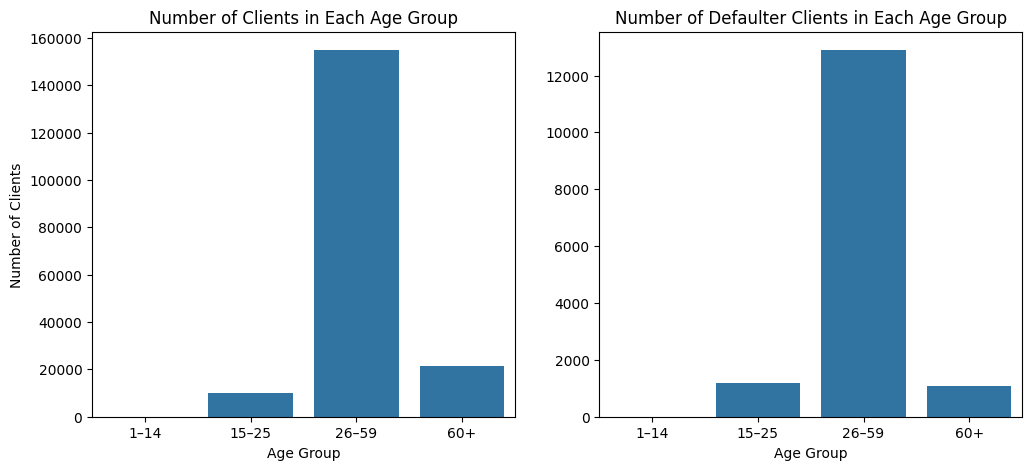

In [36]:
# Loan Distribution according to Age

plt.figure(figsize=(12, 5))   
# Plot 1
plt.subplot(1, 2, 1) # axis 1
sns.countplot(data=main, x='AGE_BIN')
plt.title('Number of Clients in Each Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Clients')

# Plot 2
plt.subplot(1, 2, 2) # axis 2
sns.countplot(data=main[main["TARGET"]==1], x='AGE_BIN')
plt.title('Number of Defaulter Clients in Each Age Group')
plt.xlabel('Age Group')
plt.ylabel("")
plt.show()

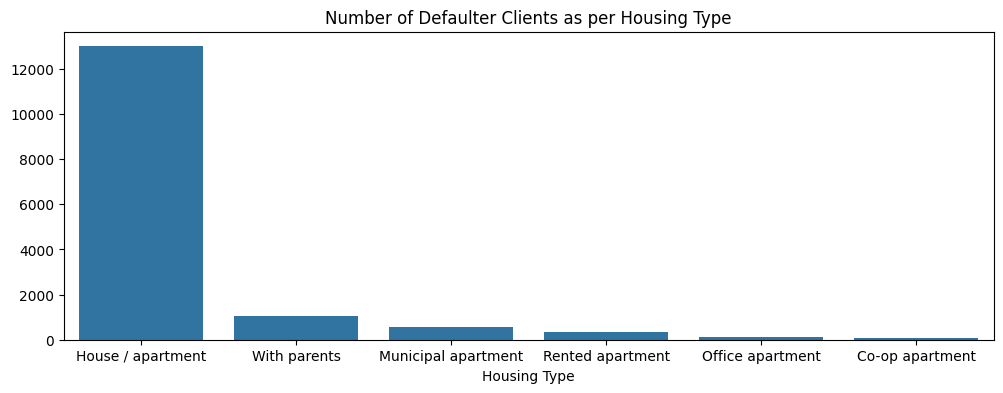

In [37]:
# Number of Defaulter Clients as per Income Type

plt.figure(figsize=(12,4))
sns.countplot(data=main[main["TARGET"]==1], x='NAME_HOUSING_TYPE')
plt.title('Number of Defaulter Clients as per Housing Type')
plt.xlabel('Housing Type')

plt.ylabel("")
plt.show()

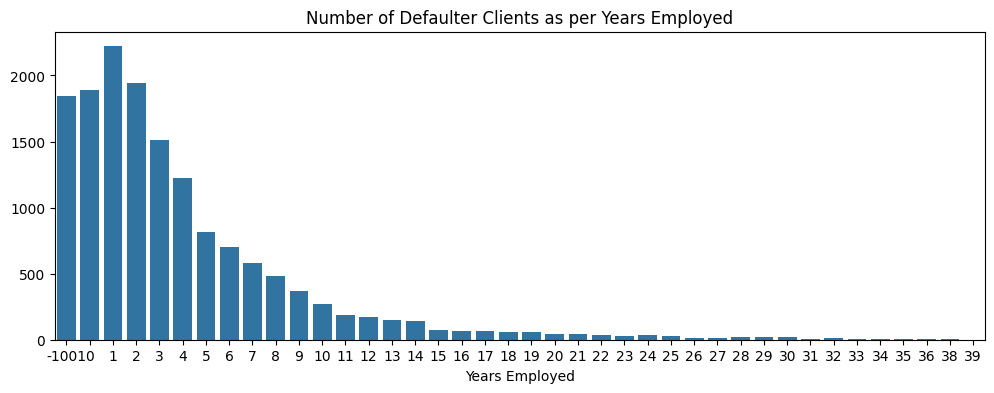

In [38]:
# Number of Defaulter Clients as per Years Employed

plt.figure(figsize=(12,4))
sns.countplot(data=main[main["TARGET"]==1], x='YEARS_EMPLOYED')
plt.title('Number of Defaulter Clients as per Years Employed')
plt.xlabel('Years Employed')

plt.ylabel("")
plt.show()

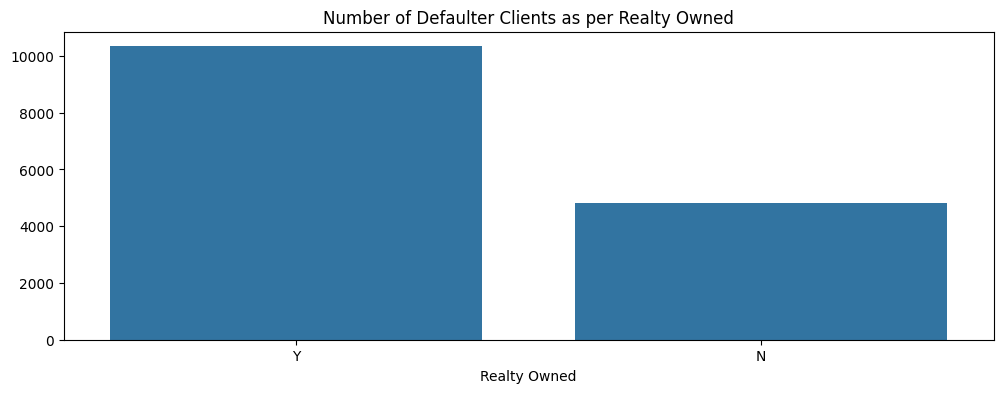

In [39]:
# Number of Defaulter Clients as per Realty Owned

plt.figure(figsize=(12,4))
sns.countplot(data=main[main["TARGET"]==1], x='FLAG_OWN_REALTY')
plt.title('Number of Defaulter Clients as per Realty Owned')
plt.xlabel('Realty Owned')

plt.ylabel("")
plt.show()

### 2. LOAN ATTRIBUTES

    'WEEKDAY_APPR_PROCESS_START', 'TARGET', 'NAME_CONTRACT_TYPE', 'AMT_CREDIT', 'AMT_ANNUITY', 'HOUR_APPR_PROCESS_START', 'AMT_GOODS_PRICE'

In [40]:
# Default Rate

default_rate = main['TARGET'].mean()
print(f"Default Rate: {default_rate:.2%}")

Default Rate: 8.13%


- Imbalanced Dataset.

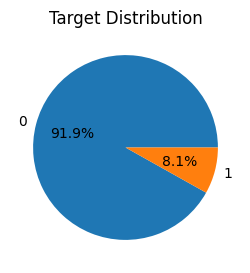

In [41]:
# Target Distribution across Data

target_dist = main['TARGET'].value_counts()
target_dist.plot.pie(autopct='%1.1f%%', figsize=(3, 3), title='Target Distribution') 
plt.ylabel("")
plt.show()

- 0: customer repaid on time (majority class — 91%)
- 1: customer had difficulty paying back (minority class — 9%)

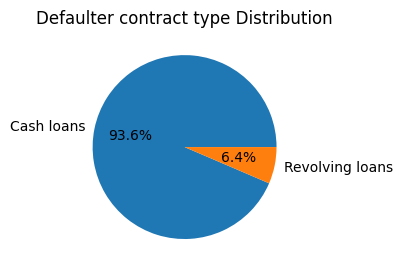

In [42]:
# Defaulter contract type Distribution

target_dist = main[main['TARGET']==1]["NAME_CONTRACT_TYPE"].value_counts()
target_dist.plot.pie(autopct='%1.1f%%', figsize=(4,4), title='Defaulter contract type Distribution')
plt.ylabel("") 

plt.tight_layout()
plt.show()

- People who have taken Cash Loans are more likely to be Defaulters.

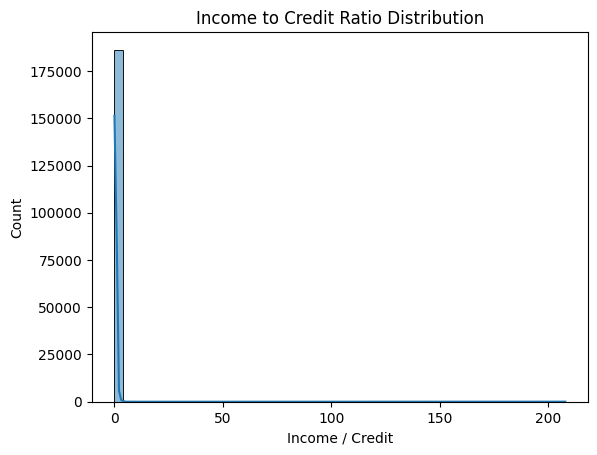

In [43]:
# Income by Credit.

sns.histplot(main["INCOME_BY_CREDIT"], bins=50, kde=True)
plt.title("Income to Credit Ratio Distribution")
plt.xlabel("Income / Credit")
plt.ylabel("Count")
plt.show()


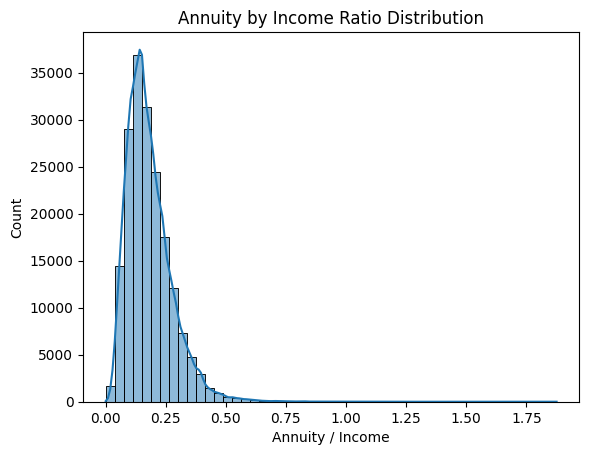

In [44]:
# Annuty by Income.

sns.histplot(main["ANNUITY_BY_INCOME"], bins=50, kde=True)
plt.title("Annuity by Income Ratio Distribution")
plt.xlabel("Annuity / Income")
plt.ylabel("Count")
plt.show()

### Income/Credit and Annuity/Income Ratio Analysis

- **Skewness**: Both features are highly right-skewed.
- **Interpretation**: Most clients have moderate ratios; a few have very high income or low annuity, skewing the distribution.
- **Impact**: Could affect model learning and lead to bias or overfitting.
- **Action to be Taken**:
  - Apply log transformation: `log1p(INCOME / CREDIT)` and `log1p(ANNUITY / INCOME)
- **Business Insight**: High ratios may indicate financially sound applicants, but they are rare.

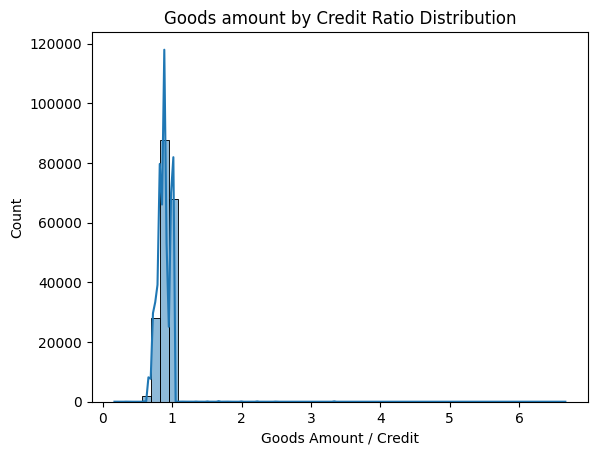

In [45]:
# Goods amount by Income.

sns.histplot(main["GOODS_AMT_BY_CREDIT"], bins=50, kde=True)
plt.title("Goods amount by Credit Ratio Distribution")
plt.xlabel("Goods Amount / Credit")
plt.ylabel("Count")
plt.show()

### **Merging main and bureau Datasets**

In [50]:
# Creating new features

bureau["DEBT_CREDIT_RATIO"] = bureau["AMT_CREDIT_SUM_DEBT"] / bureau["AMT_CREDIT_SUM"]
bureau["HAS_OVERDUE"] = (bureau["AMT_CREDIT_SUM_OVERDUE"] > 0).astype(int)
bureau["IS_ACTIVE"] = (bureau["CREDIT_ACTIVE"] == "Active").astype(int)

# Aggregate features
bureau_agg = bureau.groupby("SK_ID_CURR").agg({
    "AMT_CREDIT_SUM": ["sum", "mean"],
    "AMT_CREDIT_SUM_DEBT": ["sum", "mean"],
    "DEBT_CREDIT_RATIO": "mean",
    "HAS_OVERDUE": "sum",
    "IS_ACTIVE": "sum",
    "DAYS_CREDIT": ["mean", "min"],
})

# Flatten column names
bureau_agg.columns = ["BUREAU_" + "_".join(col).upper() for col in bureau_agg.columns]
bureau_agg.reset_index(inplace=True)

# Merge with main application
main = main.merge(bureau_agg, on="SK_ID_CURR", how="left")


#### Handling Null Values

In [ ]:
# List of columns to impute
bureau_features = [
    'BUREAU_AMT_CREDIT_SUM_SUM',
    'BUREAU_AMT_CREDIT_SUM_MEAN',
    'BUREAU_AMT_CREDIT_SUM_DEBT_SUM',
    'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
    'BUREAU_DEBT_CREDIT_RATIO_MEAN',
    'BUREAU_HAS_OVERDUE_SUM',
    'BUREAU_IS_ACTIVE_SUM',
    'BUREAU_DAYS_CREDIT_MEAN',
    'BUREAU_DAYS_CREDIT_MIN'
]

# Apply median imputation
for col in bureau_features:
    median_value = main[col].median()
    main[col].fillna(median_value, inplace=True)


In [55]:
main.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'FLAG_CONT_MOBILE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'OCCUPATION_TYPE_NAN_FLAG', 'EXT_SOURCE_3_NAN_FLAG',
       'YEARS_BEGINEXPLUATATION_AVG_NAN_FLAG', 'FLOORSMAX_AVG_NAN_FLAG',
       'AMT_REQ_CREDIT_BUREAU_YEAR_NAN_FLAG', 'AGE_YEARS', 'YEARS_EMPLOYED',
       'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH', 'DEF_30_RATIO',
       'DEF_60_RATIO', 'INCOME_BY_CREDIT', 'GOODS_AMT_BY_CREDIT', 'AGE_BIN',
       'ANNUITY_BY_INCOME', '

In [56]:
# Function to calculate WoE and IV
def calculate_woe_iv(df, feature, target, bins=10):
    temp_df = df[[feature, target]].copy().dropna()
    
    # If numerical, bin the feature
    if pd.api.types.is_numeric_dtype(temp_df[feature]):
        try:
            temp_df['bin'] = pd.qcut(temp_df[feature], q=bins, duplicates='drop')
        except ValueError:
            temp_df['bin'] = temp_df[feature]  # fallback
    else:
        temp_df['bin'] = temp_df[feature]

    grouped = temp_df.groupby('bin')[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'bads']
    grouped['goods'] = grouped['total'] - grouped['bads']
    grouped['bad_rate'] = grouped['bads'] / grouped['bads'].sum()
    grouped['good_rate'] = grouped['goods'] / grouped['goods'].sum()
    grouped['woe'] = np.log((grouped['good_rate'] + 1e-4) / (grouped['bad_rate'] + 1e-4))
    grouped['iv'] = (grouped['good_rate'] - grouped['bad_rate']) * grouped['woe']

    iv = grouped['iv'].sum()
    return grouped[['woe']], iv



In [57]:
# IV summary for all features
def iv_summary(df, target, bins=10):
    iv_list = []
    for col in df.columns:
        if col == target:
            continue
        try:
            _, iv = calculate_woe_iv(df[[col, target]].dropna(), col, target, bins)
            iv_list.append((col, iv))
        except Exception as e:
            iv_list.append((col, np.nan))
    return pd.DataFrame(iv_list, columns=['Feature', 'IV']).sort_values(by='IV', ascending=False)


In [58]:
# Calculate IV for each feature
iv_result = iv_summary(main, target='TARGET')
iv_result

C:\Users\kanis\AppData\Local\Temp\ipykernel_18264\4197934467.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp_df.groupby('bin')[target].agg(['count', 'sum'])
C:\Users\kanis\AppData\Local\Temp\ipykernel_18264\4197934467.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp_df.groupby('bin')[target].agg(['count', 'sum'])
C:\Users\kanis\AppData\Local\Temp\ipykernel_18264\4197934467.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the

,Feature,IV
45,BUREAU_DEBT_CREDIT_RATIO_MEAN,0.385114
48,BUREAU_DAYS_CREDIT_MEAN,0.118133
8,AMT_GOODS_PRICE,0.095891
31,AGE_YEARS,0.084791
32,YEARS_EMPLOYED,0.073660
38,GOODS_AMT_BY_CREDIT,0.071267
19,ORGANIZATION_TYPE,0.071008
49,BUREAU_DAYS_CREDIT_MIN,0.070346
9,NAME_INCOME_TYPE,0.054899
44,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,0.051523


🧮 IV Interpretation:
IV Value	Predictive Power
- less than 0.02:	Useless
- 0.02 – 0.1:	Weak
- 0.1 – 0.3:	Medium
- 0.3 – 0.5:	Strong
- more than 0.5:	Suspiciously good (check for leakage)

In [61]:
iv_result[iv_result["Feature"] > 0.02]

TypeError: '>' not supported between instances of 'str' and 'float'